# Plot a mix of PLA and Model Results. 

3x1 Plot

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing Code

In [3]:
replace_poly_dict = {
    "MPNN_global_pm": r"${MPNN_{\mathrm{chiral}}}$",
    "MPNN_global_pm_no_ctag": r"${MPNN_{\mathrm{pm}}}$",
    "MPNN_ctag": r"${MPNN_{\mathrm{ctag}}}$",
    "MPNN_no_chiral": r"${MPNN_{\mathrm{nochiral}}}$",
    "RF_no_pm": "RF$_{achiral}$",
    "RF_pm": "RF$_{chiral}$",
    "GB_nopm": r"${GB_\mathrm{nochiral}}}$",
    "GB_pm": r"${GB_\mathrm{{chiral}}}$",
}

{r"${MPNN_{\mathrm{pm}}}$": "o", r"${MPNN_{\mathrm{ctag}}}$": "D"}

replace_PLA_dict = {
    "Chiral": r"${MPNN_{\mathrm{chiral}}}$",
    "Nonchiral": r"${MPNN_{\mathrm{nochiral}}}$"
}

replace_var_dict = {"Tm_MAE": "T$_{m}$ MAE", "Tg_MAE": "T$_{g}$ MAE", "Tg_RMSE": "T$_{g}$ RMSE", "Tm_RMSE": "T$_{m}$ RMSE"}

## PLA Example

In [4]:
df_PLA = pd.read_csv("./data/individual_df.csv")
df_PLA = df_PLA.reset_index(drop=True)
df_PLA.loc[:, "Model"] = df_PLA.Model.apply(lambda s: replace_PLA_dict[s])

## Poly Performance Results

In [5]:
kfold_err_df = pd.read_csv("../../data/dataframes/full_err_MPNN_df.csv")
df_allmodel = kfold_err_df.melt(id_vars=["model", "model_id"], value_vars=["Tm_MAE", "Tg_MAE", "Tm_RMSE", "Tg_RMSE"])

df_poly = df_allmodel.copy()
df_poly.loc[:, "model"] = df_poly.model.map(lambda s: replace_poly_dict[s] if s in replace_poly_dict.keys() else None)

poly_order_map = ["MPNN_global_pm_no_ctag", "MPNN_global_pm", "MPNN_ctag", "MPNN_no_chiral"]
poly_order_map = {k: i for i, k in enumerate(poly_order_map)}

df_poly = df_allmodel[df_allmodel.model.str.contains("|".join([i + "$" for i in poly_order_map]))].copy()
df_poly.loc[:, "model"] = df_poly.model.apply(lambda s: replace_poly_dict[s])
df_poly.loc[:, "variable"] = df_poly.variable.apply(lambda s: replace_var_dict[s])
order_map = {replace_poly_dict[k]: i for i, k in enumerate(poly_order_map)}

# All Model Performance Results

In [6]:
df_gbpm = pd.read_csv("./GB_training/GB_results/GB_pm_results.csv")
df_gbnopm = pd.read_csv("./GB_training/GB_results/GB_nopm_results.csv")
df_mpnn = pd.read_csv("./GB_training/GB_results/MPNN_results.csv")

def rmse(x):
    x = x**2
    x = x.mean()
    x = x**(1/2)
    return x

def mae(x):
    x = abs(x)
    return x.mean()

agg_dict = {
    "Tg_diff": [mae, rmse],
    "Tm_diff": [mae, rmse]
}

df_full_raw_allmodel = pd.concat([df_gbpm, df_gbnopm, df_mpnn])

df_full_raw_allmodel["Tm_diff"] = df_full_raw_allmodel.Tm - df_full_raw_allmodel.Tm_pred
df_full_raw_allmodel["Tg_diff"] = df_full_raw_allmodel.Tg - df_full_raw_allmodel.Tg_pred
df_allmodel = df_full_raw_allmodel.groupby(["model", "model_id"]).agg(agg_dict).reset_index()
df_allmodel.columns = list(map('_'.join, df_allmodel.columns.values))
df_allmodel = df_allmodel.rename(columns={"model_": "model", "model_id_": "model_id", "Tg_diff_mae": "Tg_MAE", "Tg_diff_rmse": "Tg_RMSE", "Tm_diff_mae": "Tm_MAE", "Tm_diff_rmse": "Tm_RMSE"})
df_allmodel = df_allmodel[df_allmodel.model.isin(["GB_nopm", "GB_pm", "MPNN_global_pm", "MPNN_no_chiral"])]
df_allmodel = df_allmodel.melt(id_vars=["model", "model_id"], value_vars=["Tm_MAE", "Tg_MAE", "Tm_RMSE", "Tg_RMSE"])

order_map_all_dict = {
    "MPNN_global_pm": 0,
    "GB_pm": 4,
    "MPNN_no_chiral": 7,
    "GB_nopm": 8,
}

order_map_all_dict = {replace_poly_dict[key]: val for key, val in order_map_all_dict.items()}
replace_var_dict = {"Tm_MAE": "T$_{m}$ MAE", "Tg_MAE": "T$_{g}$ MAE", "Tg_RMSE": "T$_{g}$ RMSE", "Tm_RMSE": "T$_{m}$ RMSE"}

df_allmodel["model"] = df_allmodel.model.apply(lambda s: replace_poly_dict[s])
df_allmodel["ordering"] = df_allmodel.model.apply(lambda s: order_map_all_dict[s])
df_allmodel = df_allmodel.sort_values(by="ordering")

# Plots

/var/folders/mn/k32kn37x5ldgpp51c6cdmkpm0000gn/T/ipykernel_10400/2624745532.py:89: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pdi" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./PLA_and_Results_Figure.png", pdi=300)


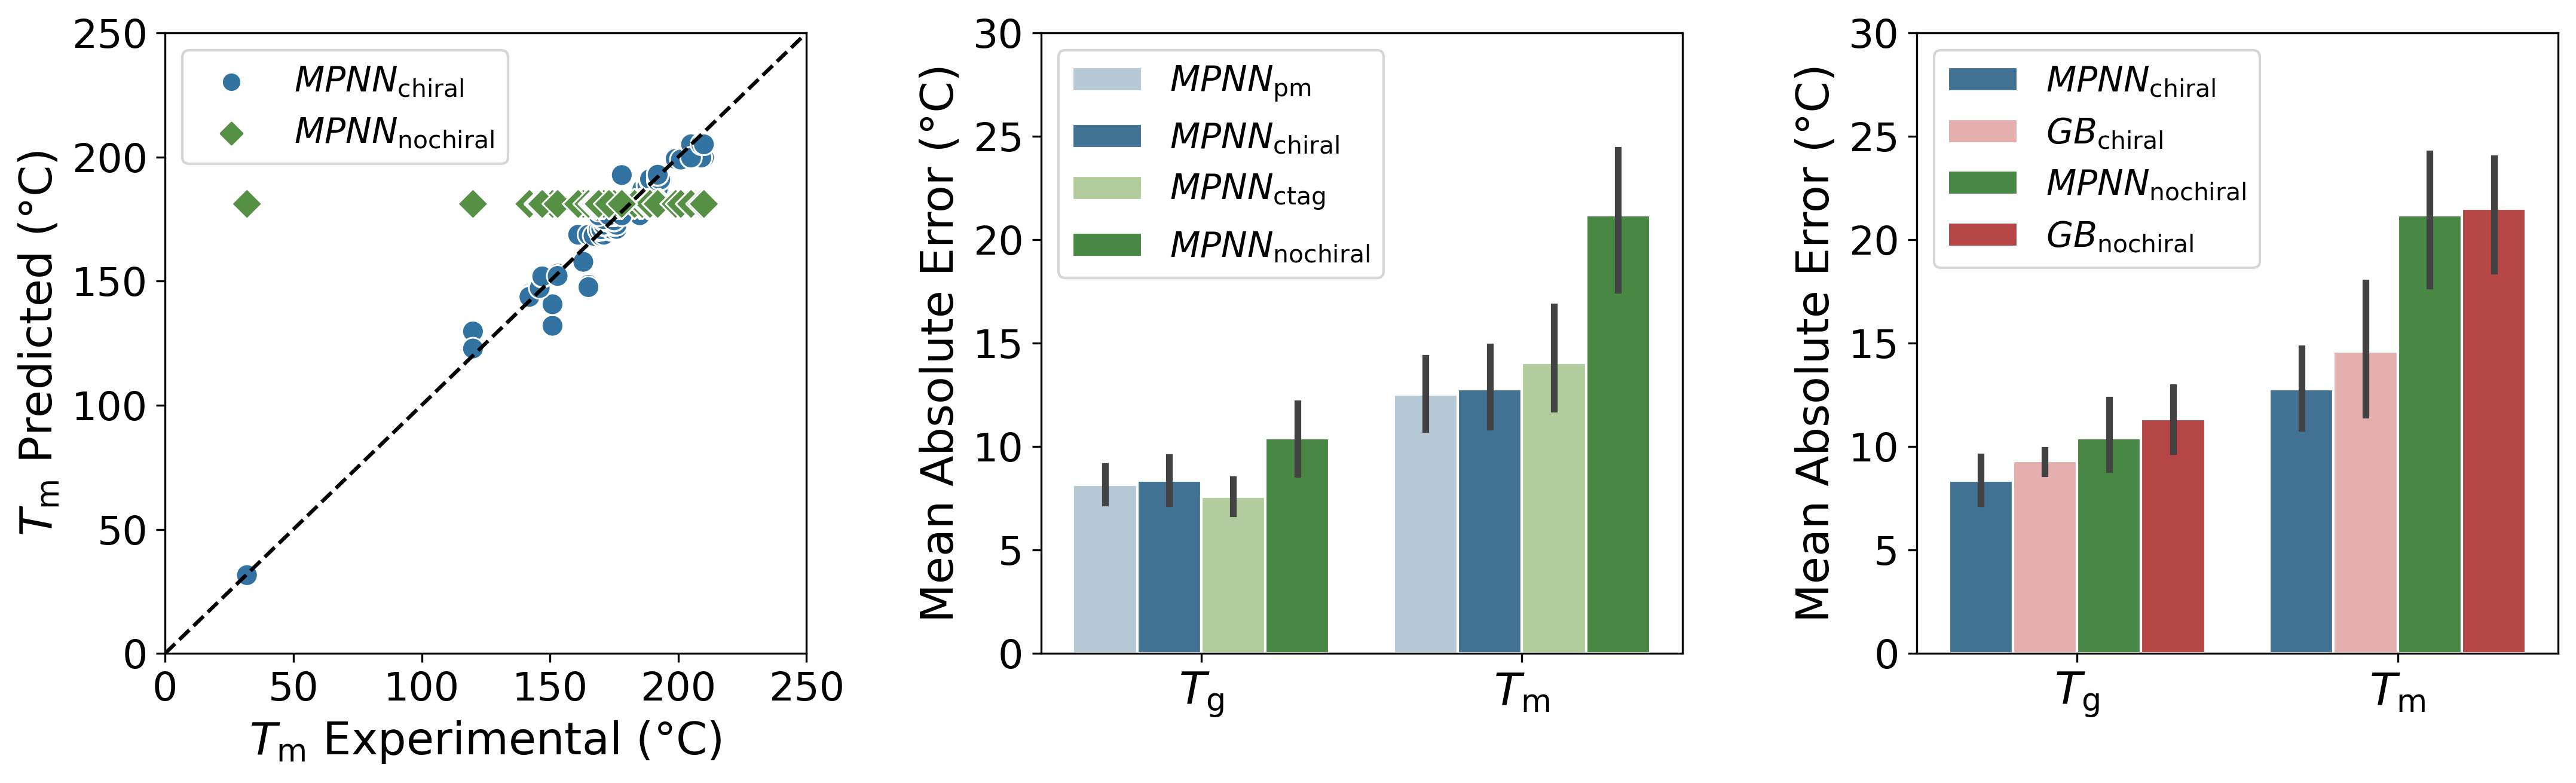

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
label_size = 18
tick_size = 16
legend_size = 14

######## Plot PLA First
PLA_ax = axs[0]
PLA_markers = {r"${MPNN_{\mathrm{chiral}}}$": "o", r"${MPNN_{\mathrm{nochiral}}}$": "D"}
PLA_scatter_params = {"s": 75}
sns.scatterplot(
    x="Tm", y="Tm_pred", data=df_PLA[df_PLA.model_id == 0],
    style="Model", hue="Model",
    markers=PLA_markers, palette=["#3373a1", "#569045"],
    **PLA_scatter_params,
    ax=PLA_ax
)

# Axes labels and ticks
PLA_ax.set_ylabel(r"${T_\mathrm{{m}}}$ Predicted (°C)", fontsize=label_size)
PLA_ax.set_xlabel(r"${T_\mathrm{{m}}}$ Experimental (°C)", fontsize=label_size)
PLA_ax.tick_params(axis='x', labelsize=tick_size)
PLA_ax.tick_params(axis='y', labelsize=tick_size)

# Limits
PLA_ax.set_ylim(0, 250)
PLA_ax.set_xlim(0, 250)

# Legend
PLA_ax.legend(loc='best', markerscale=1, fontsize=legend_size)

# Line of Parity
PLA_ax.plot([0, 250], [0, 250], linestyle="--", color='k')
######## PLA Plot Done

######## Plot Poly only Model Performance
poly_legend_labels = {r"${MPNN_{\mathrm{pm}}}$": "o", r"${MPNN_{\mathrm{ctag}}}$": "D"}
poly_ax = axs[1]
sns.barplot(y="value",
            x="variable",
            data=df_poly,
            ax=poly_ax,
            palette=["#afccdb", "#3373A1", "#b2d495", "#409239"],
            hue="model",
            hue_order=order_map.keys(),
            order=["T$_{g}$ MAE", "T$_{m}$ MAE"],#, "Tg_RMSE", "Tm_RMSE"],
            edgecolor="white"
           )

# Axes labels and ticks
poly_ax.set_ylabel("Mean Absolute Error (°C)", fontsize=label_size)
poly_ax.set_xlabel("", fontsize=label_size)
poly_ax.set_xticklabels([r"$T_\mathrm{g}$", r"$T_\mathrm{m}$"])
poly_ax.tick_params(axis='x', labelsize=label_size)
poly_ax.tick_params(axis='y', labelsize=tick_size)

poly_ax.set_ylim(0, 30)

# Legend
poly_ax.legend(ncol=1, loc='upper left', fontsize=legend_size)
######## Plot Poly only Model Performance

######## Plot All Comparison only Model Performance
all_ax = axs[2]
sns.barplot(
    y="value",
    x="variable",
    data=df_allmodel,
    ax=all_ax,
    palette=["#3373A1", "#EEA6A5", "#409239", "#CA3335"],
    hue="model", order=["Tg_MAE", "Tm_MAE"],
    edgecolor="white"
)

# Axes labels and ticks
all_ax.set_ylabel("Mean Absolute Error (°C)", fontsize=label_size)
all_ax.set_xlabel("", fontsize=label_size)
all_ax.set_xticklabels([r"$T_\mathrm{g}$", r"$T_\mathrm{m}$"])
all_ax.tick_params(axis='x', labelsize=label_size)
all_ax.tick_params(axis='y', labelsize=tick_size)

all_ax.set_ylim(0, 30)

# Legend
all_ax.legend(ncol=1, loc='upper left', fontsize=legend_size)
######## Plot All Comparison only Model Performance

plt.tight_layout(pad=3)

plt.savefig("./PLA_and_Results_Figure.png", pdi=300)

In [25]:
df_allmodel.groupby(by=["model", "variable"]).agg("mean")

model_id      value  ordering
model                        variable                               
${GB_\mathrm{nochiral}}}$    Tg_MAE         4.5  11.332890       8.0
                             Tg_RMSE        4.5  20.746822       8.0
                             Tm_MAE         4.5  21.501564       8.0
                             Tm_RMSE        4.5  33.343501       8.0
${GB_\mathrm{{chiral}}}$     Tg_MAE         4.5   9.317754       4.0
                             Tg_RMSE        4.5  17.126439       4.0
                             Tm_MAE         4.5  14.598838       4.0
                             Tm_RMSE        4.5  26.758250       4.0
${MPNN_{\mathrm{chiral}}}$   Tg_MAE         4.5   8.365371       0.0
                             Tg_RMSE        4.5  15.605507       0.0
                             Tm_MAE         4.5  12.787682       0.0
                             Tm_RMSE        4.5  25.644718       0.0
${MPNN_{\mathrm{nochiral}}}$ Tg_MAE         4.5  10.421820       7.0
                             Tg_RMSE        4.5  19.087605       7.0
                             Tm_MAE         4.5  21.183113       7.0
                             Tm_RMSE        4.5  34.710611       7.0

In [21]:
df_poly[df_poly.model == "${MPNN_{\mathrm{chiral}}}$"]

,model,model_id,variable,value
20,${MPNN_{\mathrm{chiral}}}$,0,T$_{m}$ MAE,14.124822
21,${MPNN_{\mathrm{chiral}}}$,1,T$_{m}$ MAE,12.941473
22,${MPNN_{\mathrm{chiral}}}$,2,T$_{m}$ MAE,14.911811
23,${MPNN_{\mathrm{chiral}}}$,3,T$_{m}$ MAE,19.863166
24,${MPNN_{\mathrm{chiral}}}$,4,T$_{m}$ MAE,12.682349
25,${MPNN_{\mathrm{chiral}}}$,5,T$_{m}$ MAE,7.243072
26,${MPNN_{\mathrm{chiral}}}$,6,T$_{m}$ MAE,12.573902
27,${MPNN_{\mathrm{chiral}}}$,7,T$_{m}$ MAE,12.373782
28,${MPNN_{\mathrm{chiral}}}$,8,T$_{m}$ MAE,10.915771
29,${MPNN_{\mathrm{chiral}}}$,9,T$_{m}$ MAE,10.246676


In [22]:
df_poly

,model,model_id,variable,value
10,${MPNN_{\mathrm{ctag}}}$,0,T$_{m}$ MAE,22.280873
11,${MPNN_{\mathrm{ctag}}}$,1,T$_{m}$ MAE,14.016627
12,${MPNN_{\mathrm{ctag}}}$,2,T$_{m}$ MAE,11.005036
13,${MPNN_{\mathrm{ctag}}}$,3,T$_{m}$ MAE,19.873655
14,${MPNN_{\mathrm{ctag}}}$,4,T$_{m}$ MAE,13.017282
...,...,...,...,...
345,${MPNN_{\mathrm{nochiral}}}$,5,T$_{g}$ RMSE,22.551049
346,${MPNN_{\mathrm{nochiral}}}$,6,T$_{g}$ RMSE,19.957491
347,${MPNN_{\mathrm{nochiral}}}$,7,T$_{g}$ RMSE,13.033303
348,${MPNN_{\mathrm{nochiral}}}$,8,T$_{g}$ RMSE,24.973323


In [9]:
a = 0.1 + 0.1 + 0.1
b = 1.0
c = sum([0.1]*10)

b == c

False

In [10]:
sum([0.1] * 10) == 1.0

False